In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from data_preprocess import dataFormatter
from skimage import data, exposure
from model import Model
import copy
from sklearn.model_selection import train_test_split
%load_ext autoreload
%autoreload 2
import dlib
from time import time


# Project : O.Frelot A.Guiot

In [3]:
csv  = pd.read_csv('../challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv')
# we filter our data set and only keep images 'happy', 'sad', 'angry'
csv = csv[(csv.emotion ==0) | (csv.emotion==3) | (csv.emotion==4)]
data = copy.deepcopy(csv)

In [4]:
emotions_mapping = dict({0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'})

In [5]:
def get_image(index):
    img = np.array([int(i) for i in data.pixels.values[index].split()]).reshape((48,48))
    return img

def plot_image(index= 10):
    plt.figure(figsize=(6,4))
    img = get_image(index)
    plt.imshow(img, cmap='gray')
    plt.title(emotions_mapping[data.emotion.values[index]])

In [6]:
data_train, data_test = train_test_split(csv)

data_formatter_train = dataFormatter(data_train)
data_formatter_test = dataFormatter(data_test)

# Abstract
In this project, we will focus on an image classification problem. Our dataset contains a huge number of labelled images representing human faces with different face expression ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'). The idea is to classify these images into these 7 categories. The state of the art of this problem has been done using a deep learning approach in [1] which obtains 75% of accuracy, a Convolutional Neural Network was used during several hours on GPU to obtain these results. Here we want to approach this problem with a much simpler algorithm. Our idea is to try two different approaches : 
- Using HoG features 
- Using faces landmarks features 
- Both  

Moreover to simplify the problem we will reduce the number of categories (we will keep: "Angry", "Happy" and "Sad").
At first, we will start with 3 categories and then move to 7 categories to see the impact on our accuracy. In the end, we succeeded to obtain a score of around XX % (for 3 categories) which is far from the state of the art. But not to bad against the random prediction (0.33).

# Introduction  
As we know, deep learning approach is the state of the art of visual computing problems. For this case, the best score has been obtained using a convolutional neural network in [1].  
Here we would like to try a much simpler approach using HoG features.  
The main idea of our idea is to see if a simple algorithm can provide a good performance. Indeed, a neural netwok can be very long to train (several hours on multi GPU for the face expression problem). Here we will try to classify our images using a simple support verctor machine (SVM) algorithm. The training time for this type of algorithm is very face (around 1 minute).  This might be usefull if we want to train a model on a huge amount ouf data or on a dataset of high quality images

# Problem Definition
### Data set description  
Our data set contains 16040 images of labeled data. Each image is described with 48x48 pixels (2304 pixels).  

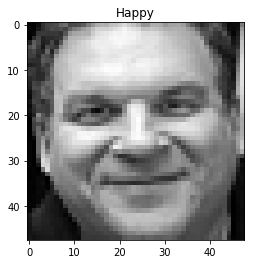

In [7]:
plot_image(7)

The distribution of the categories is as follows : 

In [8]:
emotions_mapping
repartition = csv.emotion.value_counts(True)
repartition.index = repartition.index.map(emotions_mapping)
print(repartition)

Happy    0.449813
Sad      0.301122
Angry    0.249065
Name: emotion, dtype: float64


The data set is unbalenced (all categories doesn't contain the same number of image) 

# Methodology

### HoG features  
Here we will explain how to describe an image using HoG features :  
This could be done in several steps :   
- Calculate the Gradient Images   

At first we compute the gradient $g_x $ and $g_y$  
then :   
$ g= \sqrt{g_x + g_y} $  
$ \theta = arctan(\frac{g_y}{g_x}) $ 

- Calculate Histogram of Gradients in 4×4 cells  

In this step, the image is divided into cells each cells contains 4x4 pixels and a histogram of gradients is calculated for each cell. The histogram contains 9 (as recommended in the original paper) bins corresponding to angles 0, 20, 40 … 160. 

- Normalization  

The next step of the process in to normalise each gradient histogram. Indeed some part of the image might have a bigger brigtness than others. This could lead to a difference in gradient histograms. 

The idea is to normalize each histogram  over a bigger sized block of 8×8. A 8×8 block has 4 histograms which can be concatenated into one vector and can be normalized. Then we can move this 8x8 block by 4 pixel and then recompute the normalization in the block.


<img src="hog_features.png" alt="Drawing" style="width: 400px;" />


Below the result for our case

In [9]:
hog_image_train = data_formatter_train.compute_hog()
hog_image_test = data_formatter_test.compute_hog()

/anaconda3/lib/python3.7/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
/anaconda3/lib/python3.7/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
/Users/antoineguiot/Documents/OMA/VIC/project/project_vic/data_preprocess.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['hog_features'] = hog_features


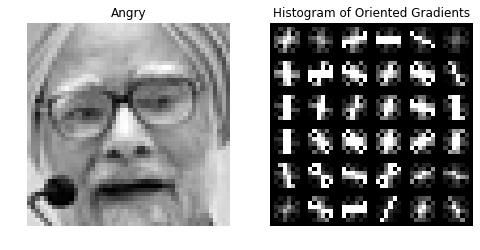

In [10]:
index = 1

hog_image_rescaled = exposure.rescale_intensity(hog_image_train[index], in_range=(0, 10))
img = get_image(index)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.set_title(emotions_mapping[csv.emotion.values[index]])
ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)

# Rescale histogram for better display

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

### lbp features  
Here we will explain how to describe an image using local_binary_pattern (lbp)   


LBP was first described in 1994. It has since been found to be a powerful feature for texture classification; it has further been determined that when LBP is combined with the Histogram of oriented gradients (HOG) descriptor, it improves the detection performance considerably on some datasets.  

The LBP feature vector, in its simplest form, is created in the following manner:

- Divide the examined window into cells (e.g. 16x16 pixels for each cell) (for a 48x48 it will split the image into 9 parts)  
- For each pixel in a cell, compare the pixel to each of its 8 neighbors (on its left-top, left-middle, left-bottom, right-top, etc.). Follow the pixels along a circle, i.e. clockwise or counter-clockwise.

<img src="lbp_feature_points.png" alt="Drawing" style="width: 250px;" />


- Where the center pixel's value is greater than the neighbor's value, write "0". Otherwise, write "1". This gives an 8-digit binary number (which is usually converted to decimal for convenience).  



<img src="lbp_explained.png" alt="Drawing" style="width: 450px;" />

- Compute the histogram, over the cell, of the frequency of each "number" occurring (i.e., each combination of which pixels are smaller and which are greater than the center). Here we will create an histogram containing only 255 bins. 

<img src="hist_explain_lbp.png" alt="Drawing" style="width: 300px;" />



- Concatenate histograms of all cells. This gives a feature vector for the entire window.  

We will implement the methods explained in the article from Caifeng Shan, Shaogang Gong and Peter W. McOwan [2] 


In [11]:
lbp_train = data_formatter_train.compute_lbp()
lbp_test = data_formatter_test.compute_lbp()

/Users/antoineguiot/Documents/OMA/VIC/project/project_vic/data_preprocess.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['lbp'] = lbp_hist_list
/Users/antoineguiot/Documents/OMA/VIC/project/project_vic/data_preprocess.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['is_lbp_nan'] = np.sum(np.stack(self.data.lbp.values), axis=1)


### Landmarks features  #TODO
Facial landmarks are used to localize and represent salient regions of the face, such as:  

- Eyes
- Eyebrows
- Nose
- Mouth
- Jawline  

Facial landmarks have been successfully applied to face alignment, head pose estimation, face swapping, blink detection and much more.  

Detecting facial landmarks is a subset of the shape prediction problem. Given an input image, a shape predictor attempts to localize key points of interest along the shape.

In the context of facial landmarks, our goal is detect important facial structures on the face using shape prediction methods.

Detecting facial landmarks is therefore a two step process:

- Step 1 : Localize the face in the image.  
- Step 2: Detect the key facial structures on the face ROI.

In our case : on each image we only have one face. Therefore we don't need the first step. We will just give all the image as the face to the step 2.
We will use the facial landmarks detector of the library dlib. This detector is the implementation of the paper of Kazemi and Sullivan (2014) [2].
This method is based on 2 points:
 - A set of facial landmarks labeled on an image. These images are labelled manually. 68 points surrounding the face are defined.
 - The probability of the distance between two input pixels.
 
Given this two points a model is learned to detect the facial landmark an image. There is no feature extraction, the model is only basz=ed on the pixel intensity. That's why it is very quick.

<img src="facial_landmarks.jpg" alt="Drawing" style="width: 300px;" />

In this project we will work with the dlib landmarks predicator. It computes the coordinates of 68 landmarks on each face. It also exists others predicators using more points.

<img src="image_landmarks.png" alt="Drawing" style="width: 300px;" />



In [12]:
lbp_train = data_formatter_train.compute_landmarks()
lbp_test = data_formatter_test.compute_landmarks()

/Users/antoineguiot/Documents/OMA/VIC/project/project_vic/data_preprocess.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['landmarks'] = landmarks


### Model (SVM) 
Nous alllons utiliser un modèle SVM pour classifier nos données.
Voici les valeurs des hyperparametres que nous avons choisi:
We use a Support Vector Machine (SVM) model to classify the images. This model is a linear classifier which design the hyperplan with the best margins to split the data.
- Epochs:1000 It define the maximum number of iterations that the model compute
- Kernel function: Radial Basis Function (rbf)
$K(x_1,x_2)=exp(-\gamma||x_1-x_2||^2)$
- Gamma:"scale" that means $\gamma=\frac{1}{n\_features \times X.var}$

- Decision function: ovr which means 'one versus rest'. 
Each class is  against all the other classes independently. The model create a classifier for each situation. The model creates a binary label for whether a point is in a class or not.




In [13]:
hyperparameters = dict({'random_state' : None,
                        'epochs':10000,
                        'kernel':'rbf',
                        'decision_function':'ovr',
                        'gamma':'scale'
                       })

# Evalution   

### F_1 score
To score our model, we will use the $f_1$ score.  
${\displaystyle f_{1_{i}}=\left({\frac {2}{\mathrm {recall} ^{-1}+\mathrm {precision} ^{-1}}}\right)=2\cdot {\frac {\mathrm {precision} \cdot \mathrm {recall} }{\mathrm {precision} +\mathrm {recall} }}}$   
This function compute the score for the $categorie_i$ 
Here we have more than two categories so we will use the mean $f_1$ score to compute our final score : 
$ F_1 = \frac{1}{n} \sum_{i}^{n} f_{1_i}$  

### Confusion matrix

<img src="confusion_matrix.png" alt="Drawing" style="width: 300px;" />


This matrix shows the number of good prediction, number of false positive and number of false negative per class

### SVM on HoG features

In [14]:
model = Model(model_type ='SVM',hyperparameters= hyperparameters, predictors = 'hog_features', targets=[0,3,4])
model.create_model()
debut=time()
model.train(data_formatter_train.data.dropna())
print("Training time:",time()-debut,"seconds")
print('score for 3 categories using HoG features : ', model.test(data_formatter_test.data.dropna()))

(12030, 800)
Training time: 140.27926802635193 seconds
score for 3 categories using HoG features :  0.6810473815461346


In [15]:
print("F1 score:",model.getF1Score(data_formatter_test.data.dropna()))

F1 score: 0.6460662645927512


Confusion matrix :

In [16]:
model.get_confusion_matrix(data_formatter_test.data.dropna())

,Angry,Happy,Sad
Angry,457,236,288
Happy,95,1521,222
Sad,167,271,753


### SVM on lbp features

In [17]:
model = Model(model_type ='SVM',hyperparameters= hyperparameters, predictors = 'lbp', targets=[0,3,4])
model.create_model()
debut=time()
model.train(data_formatter_train.data)
print("Training time:",time()-debut,"seconds")
print('score for 3 categories using lbp features : ', model.test(data_formatter_test.data.dropna()))


(12030, 2295)
Training time: 372.0036120414734 seconds
score for 3 categories using lbp features :  0.6349127182044888


In [18]:
print("F1 score:",model.getF1Score(data_formatter_test.data.dropna()))

F1 score: 0.5920415145396137


Confusion matrix :

In [19]:
model.get_confusion_matrix(data_formatter_test.data.dropna())

,Angry,Happy,Sad
Angry,373,289,319
Happy,120,1467,251
Sad,177,308,706


### SVM on landmarks features

In [20]:
model = Model(model_type ='SVM',hyperparameters= hyperparameters, predictors = 'landmark', targets=[0,3,4])
model.create_model()
debut=time()
model.train(data_formatter_train.data)
print("Training time:",time()-debut,"seconds")
print('score for 3 categories using landmarks features : ', model.test(data_formatter_test.data.dropna()))


(12030, 136)
Training time: 39.353312969207764 seconds
score for 3 categories using landmarks features :  0.6648379052369078


In [21]:
print("F1 score:",model.getF1Score(data_formatter_test.data.dropna()))

F1 score: 0.6165972762902588


Confusion matrix :

In [22]:
model.get_confusion_matrix(data_formatter_test.data.dropna())

,Angry,Happy,Sad
Angry,340,240,401
Happy,74,1499,265
Sad,119,245,827


### SVM on hog and lbp features

In [23]:
model = Model(model_type ='SVM',hyperparameters= hyperparameters, predictors = 'hog_and_lbp', targets=[0,3,4])
model.create_model()
debut=time()
model.train(data_formatter_train.data)
print("Training time:",time()-debut,"seconds")
print('score for 3 categories using hog and lbp features : ', model.test(data_formatter_test.data.dropna()))


(12030, 3095)
Training time: 578.8395490646362 seconds
score for 3 categories using hog and lbp features :  0.6807980049875312


In [24]:
print("F1 score:",model.getF1Score(data_formatter_test.data.dropna()))

F1 score: 0.6464236122774808


Confusion matrix :

In [25]:
model.get_confusion_matrix(data_formatter_test.data.dropna())

,Angry,Happy,Sad
Angry,464,229,288
Happy,96,1512,230
Sad,185,252,754


# Conclusions

To conclude we observe that the model with the best accuracy and F1 score is the model with HOG and LBP features The accuracy reachs 0.68 and the F1 score 0.646. 
However this result is taking more time to obtain. For the model with the HOG features the training time is 159s and 150s when we add the LBP features. For the model with the landmarks features it just takes 29s to train the model.
This training time is linked to the number of feature. There are 800 HOG features that's why the training time is so long. On the contrary it just takes 29s to train because the model has just 136 features (2 coordinates for each landmark).
Finnaly we observe that all these results are less impressive than the results which a deep learning model can reach, but the training time with a deep learning model is much more important than the one we get.

# References
[1] Christopher Pramerdorfer, Martin Kampel. "Facial Expression Recognition using Convolutional Neural Networks: State of the Art".  
[2] Facial expression recognition based on Local Binary Patterns: A comprehensive study Caifeng Shan, Shaogang Gong, Peter W. McOwan 

In [1]:
x =data_formatter_test.data.landmarks.values[7] 
#plt.scatter(x[:,0], x[:,1])
plt.scatter(np.array(x[:,0]),np.array(x[:,1]))
plt.imshow(get_image(7), cmap= 'gray')

NameError: name 'data_formatter_test' is not defined